In [1]:
from collections import namedtuple
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

# 短波長放射（日射）の多重反射を計算するモジュール

## 1. Functions  

グレージング・日除け・付属部材等の各層において、短波長日射の正面（室外）側からの透過率、背面（室内）側からの透過率、正面側からの反射率、背面側からの反射率が既知の場合に、短波長の多重反射を解いて、グレージング複合体全体の透過率および、各層で吸収される短波長の吸収率を計算する。  
添え字$i$、$j$は層の番号（0～$n$-1）であり、$n$は層の数を表す。

### 入力値  
$ \tau_{f,j} $ ：層$j$の正面側からの入射光に対する日射透過率  
$ \tau_{b,j} $ ：層$j$の背面側からの入射光に対する日射透過率  
$ \rho_{f,j} $ ：層$j$の正面側からの入射光に対する日射反射率  
$ \rho_{b,j} $ ：層$j$の背面側からの入射光に対する日射反射率

### 出力値  

$ \tau_{glz} $ ：グレージング複合体全体の透過率  
$ \alpha_j $ ：層$j$の正面側からの入射光に対する日射吸収率  

### 計算方法  

#### 層$j$のデータ構造と値の範囲

層1つにつき、$\tau_f$・$\tau_b$・$\rho_f$・$\rho_b$の組み合わせを1つの変数（タプル）で表し"layer_input"とする。  
全ての値は0.0以上1.0以下の値をとる。  
$\tau_f$ と $\rho_f$ の合計は1.0を超えない。  
$\tau_b$ と $\rho_b$ の合計は1.0を超えない。  

In [2]:
#class layer_input(namedtuple('layer_input','ly_TRSf ly_TRSb ly_REFf ly_REFb')):
#    __slots__ = ()

# ly_TRSf：正面側からの入射光に対する日射透過率
# ly_TRSf：正面側からの入射光に対する日射透過率
# ly_TRSb：背面側からの入射光に対する日射透過率
# ly_REFf：正面側からの入射光に対する日射反射率
# ly_REFb：背面側からの入射光に対する日射反射率

In [3]:
class layer_input():
    def __init__( self, TRSf, TRSb, REFf, REFb ):
        self.TRSf = TRSf
        self.TRSb = TRSb
        self.REFf = REFf
        self.REFb = REFb
        
# TRSf：正面側からの入射光に対する日射透過率
# TRSf：正面側からの入射光に対する日射透過率
# TRSb：背面側からの入射光に対する日射透過率
# REFf：正面側からの入射光に対する日射反射率
# REFb：背面側からの入射光に対する日射反射率

#### 任意の層から任意の層までの多重反射計算  

（参考：JIS A 2103：2014 5.4.2 日射透過率及び各面材の日射吸収率）

隣り合う層$i$から層$j$までの値の計算方法を以下に示す。  

$ \begin{align}\tau_{f,i,j} = \frac {\tau_{f,i,j-1}･\tau_{f,j}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ････････････････････････････････ (5.1.2-a)

$ \begin{align}\tau_{b,i,j} = \frac {\tau_{b,j}･\tau_{b,i,j-1}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ････････････････････････････････ (5.1.2-b)

$ \begin{align}\rho_{f,i,j} = \rho_{f,i,j-1} + \frac {\tau_{f,i,j-1}･\rho_{f,j}･\tau_{b,i,j-1}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ･････････････････････ (5.1.2-c)

$ \begin{align}\rho_{b,i,j} = \rho_{b,j} + \frac {\tau_{b,j}･\rho_{b,i,j-1}･\tau_{f,j}}{1-\rho_{b,i,j-1}･\rho_{f,j}}\end{align}$ ･･････････････････････････ (5.1.2-d)

ここで、

$ \tau_{f,i,j} $　：　層$i$－$j$間の正面側からの入射光に対する日射透過率  
$ \tau_{b,i,j} $　：　層$i$－$j$間の背面側からの入射光に対する日射透過率  
$ \rho_{f,i,j} $　：　層$i$－$j$間の正面側からの入射光に対する日射反射率  
$ \rho_{b,i,j} $　：　層$i$－$j$間の背面側からの入射光に対する日射反射率  

である。  

任意の層$i$－$j$間の値を求める場合は、層$i+1$, $i+2$,..., $j-2$, $j-1$, $j$というように、式(5.1.2-a)～式(5.1.2-d)を逐次代入して求める。  

ここで、$ i=j $ のときは、

$ \begin{align}\tau_{f,i,j} = \tau_{f,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-e)

$ \begin{align}\tau_{b,i,j} = \tau_{b,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-f)

$ \begin{align}\rho_{f,i,j} = \rho_{f,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-g)

$ \begin{align}\rho_{b,i,j} = \rho_{b,j}\end{align} $ ････････････････････････････････････････････ (5.1.2-h)

である。

In [4]:
# 層riから層rjの複合した、TRSf TRSb REFf REFb を算出する。
def Sol_Multi_Lay(L, ri, rj):
    
    # riとrjの数値の範囲に関するエラー処理
    if ri <  0:      raise ValueError
    if rj <  0:      raise ValueError
    if ri >  rj:     raise ValueError
    if rj >= len(L): raise ValueError

    if ri == rj:
        return L[rj]
    else:
        SML = Sol_Multi_Lay(L, ri, rj-1) #層1から層j-1の日射特性値
        #trsf = (SML.ly_TRSf * L[rj].ly_TRSf) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        trsf = (SML.TRSf * L[rj].TRSf) / (1. - SML.REFb * L[rj].REFf)
        #trsb = (L[rj].ly_TRSb * SML.ly_TRSb) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        trsb = (L[rj].TRSb * SML.TRSb) / (1. - SML.REFb * L[rj].REFf)
        #reff = SML.ly_REFf + (SML.ly_TRSf * L[rj].ly_REFf * SML.ly_TRSb) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        reff = SML.REFf + (SML.TRSf * L[rj].REFf * SML.TRSb) / (1. - SML.REFb * L[rj].REFf)
        #refb = L[rj].ly_REFb + (L[rj].ly_TRSb * SML.ly_REFb * L[rj].ly_TRSf) / (1. - SML.ly_REFb * L[rj].ly_REFf)
        refb = L[rj].REFb + (L[rj].TRSb * SML.REFb * L[rj].TRSf) / (1. - SML.REFb * L[rj].REFf)
        return layer_input(trsf, trsb, reff, refb)

#### 各層の日射吸収率

（参考：JIS A 2103：2014 5.4.2 日射透過率及び各面材の日射吸収率）

各層の値の計算方法を以下に示す。  
（JISでは添え字は1始まりであるが、本仕様書では0始まりとしている。） 

$ j = 0 $ かつ $ n = 0 $ の場合

$ \begin{align} \alpha_j = \alpha_{f,j} \end{align} $ ･･････････････････････････････････････････････ (5.1.2-i)

$ j = 0 $ かつ $ n ≠ 0 $ の場合

$ \begin{align} \alpha_j = \alpha_{f,j} + \frac {\tau_{f,0,j}･\rho_{f,j+1,n}}{1-\rho_{b,0,j}･\rho_{f,j+1,n}}･\alpha_{b,j} \end{align} $ ･･････････････････････ (5.1.2-j)

$ j = 1 $～$ n - 2 $ の場合  

$ \begin{align} \alpha_j = \frac {\tau_{f,0,j-1}}{1-\rho_{b,0,j-1}･\rho_{f,j,n}}･\alpha_{f,j} + \frac {\tau_{f,0,j}･\rho_{f,j+1,n}}{1-\rho_{b,0,j}･\rho_{f,j+1,n}}･\alpha_{b,j} \end{align} $ ････ (5.1.2-k)

$ j = n - 1 $ の場合

$ \begin{align} \alpha_j = \frac {\tau_{f,0,j-1}}{1-\rho_{b,0,j-1} \rho_{f,j,n}}･\alpha_{f,j} \end{align} $ ･････････････････････････････ (5.1.2-l)

ここで、

$ j $ ：層の番号  
$ n $ ：層の数  

である。  

また、

$ \begin{align} \alpha_{f,j} = 1 - \tau_{f,j} - \rho_{f,j} \end{align} $ ･･･････････････････････････････････ (5.1.2-m)

$ \begin{align} \alpha_{b,j} = 1 - \tau_{b,j} - \rho_{b,j} \end{align} $ ･･･････････････････････････････････ (5.1.2-n)

である。

In [5]:
# 層iの日射吸収率を算出する。
def Abs_Multi_Lay(L, rj):
    
    # 層の正面側からの入射光に対する日射吸収率
    def ABSf(M):
        #return 1. - M.ly_TRSf - M.ly_REFf
        return 1. - M.TRSf - M.REFf
    
    # 層の背面側からの入射光に対する日射吸収率
    def ABSb(M):
        #return 1. - M.ly_TRSb - M.ly_REFb
        return 1. - M.TRSb - M.REFb
    
    # 層の最背面の番号
    n = len(L) - 1
    
    # 関数リネーム
    SML = Sol_Multi_Lay
    
    # 層jの正面側からの入射光
    def Sol_Rad_f(L, rj):
        if rj == 0:
            return 1.
        else:
            #return SML(L, 0, rj - 1).ly_TRSf / (1. - SML(L, 0, rj - 1).ly_REFb * SML(L, rj, n).ly_REFf)
            return SML(L, 0, rj - 1).TRSf / (1. - SML(L, 0, rj - 1).REFb * SML(L, rj, n).REFf)
            
    # 層jの背面側からの入射光
    def Sol_Rad_b(L, rj, n):
        if rj == n:
        
            return 0.
        else:
            #return SML(L, 0, rj).ly_TRSf * SML(L, rj + 1, n).ly_REFf / ( 1. - SML(L, 0, rj).ly_REFb * SML(L, rj + 1, n).ly_REFf )
            return SML(L, 0, rj).TRSf * SML(L, rj + 1, n).REFf / ( 1. - SML(L, 0, rj).REFb * SML(L, rj + 1, n).REFf )
        
    # rjの数値の範囲に関するエラー処理
    if rj < 0: raise ValueError
    if rj > n: raise ValueError
    
    return Sol_Rad_f(L, rj) * ABSf(L[rj]) + Sol_Rad_b(L, rj, n) * ABSb(L[rj])

#### グレージング複合体全体の透過率  

グレージング複合体全体の透過率は、定義から、

$ \begin{align} \tau_{glz} = \tau_{f,0,n-1} \end{align} $ ･････････････････････････････････････････ (5.1.2-o)

となる。  

In [6]:
# グレージング複合体全体の透過率
def Sol_Trs_All(L):
    
    #return Sol_Multi_Lay(L, 0, len(L) - 1).ly_TRSf
    return Sol_Multi_Lay(L, 0, len(L) - 1).TRSf

#### Example

[1.         0.1770242  0.64427559 0.07145233 0.05924598 0.04800191]


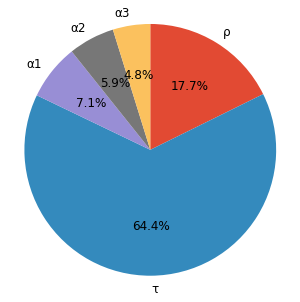

In [7]:
if __name__ == '__main__':
    ly_in = [layer_input(0.859, 0.859, 0.077, 0.077),layer_input(0.859, 0.859, 0.077, 0.077),layer_input(0.859, 0.859, 0.077, 0.077)]

    layer_result = np.zeros(len(ly_in) + 3)
    #layer_result[1] = Sol_Multi_Lay(ly_in, 0, len(ly_in) - 1).ly_REFf      #グレージング複合体全体の正面側の反射率
    layer_result[1] = Sol_Multi_Lay(ly_in, 0, len(ly_in) - 1).REFf      #グレージング複合体全体の正面側の反射率
    layer_result[2] = Sol_Trs_All(ly_in)                                 #グレージング複合体全体の透過率

    sum_abs = 0.
    for j in range(0, len(ly_in)):
        layer_result[j + 3] = Abs_Multi_Lay(ly_in, j)                    #層jの日射吸収率
        sum_abs += layer_result[j + 3]

    #グレージング複合体全体の正面側の反射率・グレージング複合体全体の透過率・層jの日射吸収率の合計
    layer_result[0] = layer_result[1] + layer_result[2] + sum_abs

    #np.savetxt('layer_result.csv', layer_result, fmt='%.10f', delimiter=',')

    print (layer_result)

    #グラフの描画
    layer_labels = np.empty(len(ly_in) + 3, dtype = np.object)
    layer_labels[0] = 'τ+ρ+α'
    layer_labels[1] = 'ρ'
    layer_labels[2] = 'τ'
    for j in range(0, len(ly_in)):
        layer_labels[j + 3] ='α' + str(j + 1)
    
    fig = plt.figure(figsize = (5, 5))
    plt.style.use('ggplot')
    ax = fig.add_subplot(1, 1, 1)
    ax.pie(layer_result[1:len(ly_in)+3], 
           labels = layer_labels[1:len(ly_in)+3], 
           autopct = '%1.1f%%', 
           pctdistance = 0.6,
           startangle = 90, 
           counterclock = False, 
           textprops = {'fontsize':12})
    plt.axis('equal')
    plt.show()